In [1]:
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, TensorDataset, Subset

/Users/DELL/opt/anaconda3/envs/data-depth/lib/python3.9/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 'dlopen(/Users/DELL/opt/anaconda3/envs/data-depth/lib/python3.9/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN3c1017RegisterOperatorsD1Ev
  Referenced from: <CC4BC91F-8B6A-3F9A-B9EB-A2B9D578E202> /Users/DELL/opt/anaconda3/envs/data-depth/lib/python3.9/site-packages/torchvision/image.so
  Expected in:     <5310731F-64FC-310E-B88B-E06F64BB3F98> /Users/DELL/opt/anaconda3/envs/data-depth/lib/python3.9/site-packages/torch/lib/libtorch_cpu.dylib'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


In [2]:
import math
import numpy as np
import pandas as pd
from scipy.linalg import eigh
import matplotlib.pyplot as plt
from scipy.spatial import distance

In [3]:
from visualization_core import *
from depth.multivariate import *
from numpy.random import RandomState
from mpl_toolkits.mplot3d import Axes3D
from scipy.spatial import ConvexHull, Delaunay
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

In [4]:
# VAE Model Definition
class VAE(nn.Module):
    def __init__(self, x_dim, hidden_dim1, hidden_dim2, z_dim=10):
        super(VAE, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(x_dim, hidden_dim1),
            nn.ReLU(),
            nn.Linear(hidden_dim1, hidden_dim2),
            nn.ReLU(),
            nn.Linear(hidden_dim2, z_dim * 2)  # Ensure this outputs twice the latent_dim for mu and logvar
        )
        self.decoder = nn.Sequential(
            nn.Linear(z_dim, hidden_dim2),
            nn.ReLU(),
            nn.Linear(hidden_dim2, hidden_dim1),
            nn.ReLU(),
            nn.Linear(hidden_dim1, x_dim),
            nn.Sigmoid()
        )

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x):
        h = self.encoder(x)
        mu, logvar = torch.chunk(h, 2, dim=1)
        z = self.reparameterize(mu, logvar)
        return self.decoder(z), z, mu, logvar

In [5]:
# Loss function
def loss_function(recon_x, x, mu, logvar):
    BCE = nn.functional.binary_cross_entropy(recon_x, x, reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + KLD

# Train VAE
def train_model(model, dataloader, learning_rate, num_epochs, max_batches=None):
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    model.train()
    for epoch in range(num_epochs):
        train_loss = 0
        for bno, batch in enumerate(dataloader):
            if max_batches != None and bno > max_batches :
                break
            x, _ = batch
            x = x.view(x.size(0), -1)
            optimizer.zero_grad()
            recon_x, z, mu, logvar = model(x)
            loss = loss_function(recon_x, x, mu, logvar)
            loss.backward()
            train_loss += loss.item()
            optimizer.step()
        print(f'Epoch {epoch + 1}, Loss: {train_loss / len(dataloader.dataset)}')
    return model

In [6]:
# Load Fashion-MNIST dataset
def load_data(normal_class=0):
    transform = transforms.Compose([transforms.ToTensor(), transforms.Lambda(lambda x: x.view(-1))])
    fashion_mnist_train = datasets.FashionMNIST(root='./data', train=True, transform=transform, download=False)
    fashion_mnist_test = datasets.FashionMNIST(root='./data', train=False, transform=transform, download=False)
    
    # Filter out only the normal class
    train_indices = [i for i, (_, label) in enumerate(fashion_mnist_train) if label == normal_class]
    normal_train = Subset(fashion_mnist_train, train_indices)
    
    return normal_train, fashion_mnist_test

In [7]:
normal_train, fashion_mnist_test = load_data(normal_class=0)  # Class 0: T-shirt/top
dataloader = DataLoader(normal_train, batch_size=128, shuffle=False)

# Define VAE model
x_dim = 28 * 28
hidden_dim1 = 512
hidden_dim2 = 256
latent_dim = 3
model = VAE(x_dim=x_dim, hidden_dim1=hidden_dim1, hidden_dim2=hidden_dim2, z_dim=latent_dim)

# Train VAE
MAX_STEPS = None #10000
trained_model = train_model(model, dataloader, learning_rate=1e-4, num_epochs=10, max_batches=MAX_STEPS)

Epoch 1, Loss: 489.79033072916667
Epoch 2, Loss: 364.6171920572917
Epoch 3, Loss: 337.66496419270834
Epoch 4, Loss: 330.1439889322917
Epoch 5, Loss: 322.34811002604164
Epoch 6, Loss: 312.06940234375
Epoch 7, Loss: 304.44474674479164
Epoch 8, Loss: 301.2178092447917
Epoch 9, Loss: 299.1314088541667
Epoch 10, Loss: 297.6971458333333


In [8]:
# Obtain latent representations
latent_space = []
labels = []
depths = np.array([])
trained_model.eval()
sample_no = 1

with torch.no_grad():
    for batch in fashion_mnist_test:
        if MAX_STEPS != None and sample_no > MAX_STEPS : 
            break
        x, y = batch
        x = x.view(-1, x.size(0))
        _, z, _, _ = trained_model(x)
        latent_space.append(z.cpu().numpy())
        labels.append(torch.tensor(y).cpu().numpy())
        sample_no += 1
    
latent_space = np.concatenate(latent_space, axis=0)
labels = np.concatenate([labels], axis=0)

# SANITY CHECK
print(latent_space.shape)
print(labels.shape)

(10000, 3)
(10000,)


In [9]:
depths = L2(latent_space, latent_space)

# SANITY CHECK
print("Number of points:", len(depths)) 
print(np.min(depths), np.max(depths))
print(np.std(depths))

Number of points: 10000
0.13166891748102014 0.3914691764657866
0.04624610996922046


In [10]:
# Set a threshold for anomalies (e.g., top 5% deepest points)
threshold = np.percentile(depths, 0.5)
print(threshold)

# get anomalies
anomalies = depths <= threshold
print("Found", len(np.where(anomalies)[0]), "anomalies")

0.18299686151981293
Found 50 anomalies


Text(0.5, 0, 'Z Label')

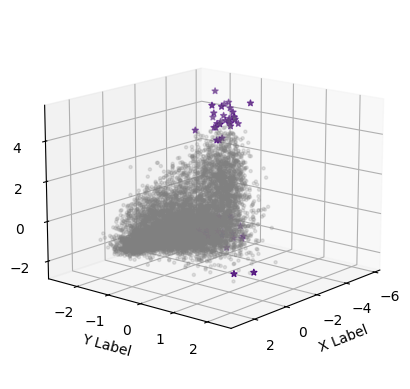

In [11]:
# Check anomalies visually
view=[15, 40, 0]
fig = plt.figure()
ax = fig.add_subplot(projection='3d')

ax.scatter(latent_space[:, 0], latent_space[:, 1], latent_space[:, 2], c='grey', marker= '.', label='Normal', alpha=0.2)
ax.scatter(latent_space[anomalies, 0], latent_space[anomalies, 1], latent_space[anomalies, 2], c='indigo', marker='*', label='Anomalies')

ax.view_init(elev=view[0], azim=view[1], roll=view[2])

ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')

In [12]:
# Construct dataframe with depth column
df = pd.DataFrame(latent_space, columns=['x', 'y', 'z'])
df['depth'] = depths
df.head()

,x,y,z,depth
0,-0.347877,0.786176,0.082397,0.307388
1,1.940162,-0.692964,-0.496842,0.329335
2,-4.458220,-1.187426,0.988066,0.266156
3,-3.293419,-0.659682,2.078373,0.261656
4,1.062921,-0.677374,0.172777,0.336528


Plotting part 1/3
Plotting part 2/3
Plotting part 3/3


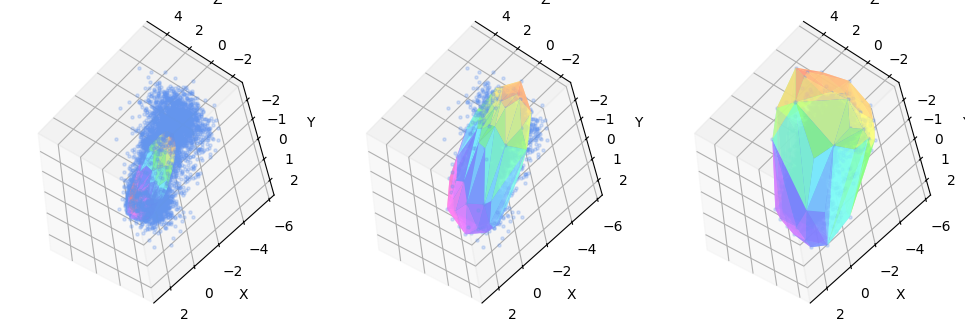

In [13]:
# Show convex hull progression with different threshold values
convex_hull_progression(df, threshold/2)

In [19]:
parts = split_dataframe_by_tolerance(df, "depth", threshold/6)[::-1]
print(len(parts))

9


Plotting part 1/9
Plotting part 2/9
Plotting part 3/9
Plotting part 4/9
Plotting part 5/9
Plotting part 6/9
Plotting part 7/9
Plotting part 8/9
Plotting part 9/9


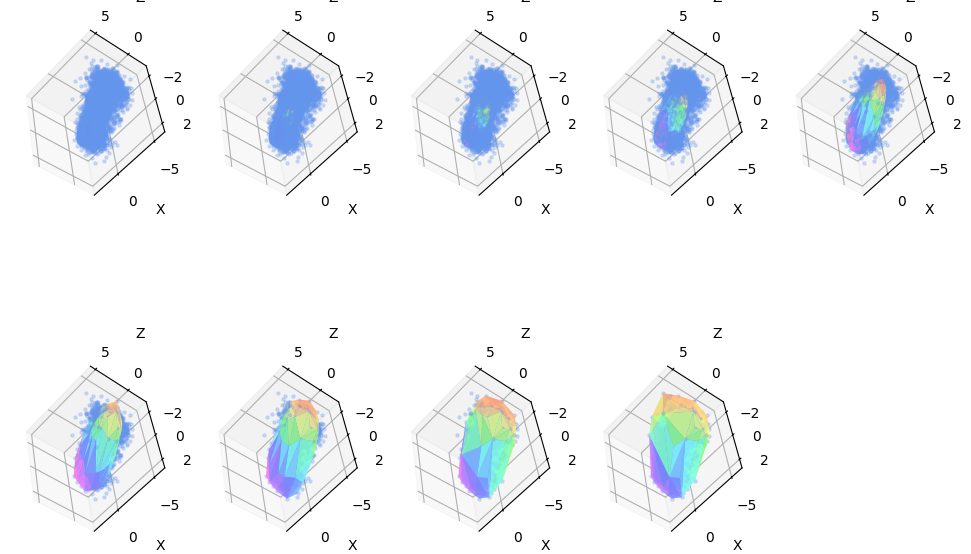

In [15]:
convex_hull_progression(df, threshold/6)

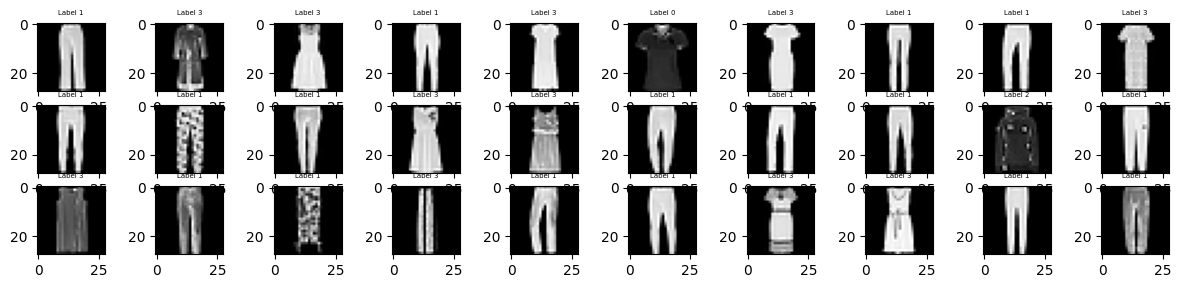

In [18]:
# Visualize original and reconstructed anomalies
anomaly_indices = np.where(anomalies)[0]

# only 30 anomalies for now
fig, axes = plt.subplots(3, 10, figsize=(15, 3))
ind = 0
row = 0
for i in anomaly_indices[:30]:  # Show up to 10 anomalies
    if ind == 10 : 
        ind = 0
        row += 1
    original = fashion_mnist_test[i][0].view(28, 28).numpy()
    with torch.no_grad():
        org = fashion_mnist_test[i][0]
        reconstructed, _, _, _ = trained_model(org.view(-1, org.size(0)))
    reconstructed = reconstructed.view(28, 28).numpy()
    row
    axes[row, ind].imshow(original, cmap='gray')
    axes[row, ind].set_title('Label ' + str(labels[i]), fontsize=5)
    ind += 1


plt.show()